# **Import các thư viện :**

In [1]:
!pip install --upgrade tensorflow==2.16.1
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [2]:
#Import các thư viện xử lý ảnh :
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tifffile as tiff
from glob import glob
import seaborn as sns 
import albumentations as albu
from skimage.io import imread
from tqdm import tqdm
import gc


#Tensorflow Imports :
import tensorflow as tf
import tensorflow.keras as k
import keras
from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence , normalize , img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Layer,
                                    Conv2DTranspose, MaxPool2D, MaxPooling2D, Dropout,
                                    Flatten, Activation, Concatenate, UpSampling2D,
                                    BatchNormalization , MaxPooling2D,
                                    Add, Multiply, Lambda, GlobalAveragePooling2D, 
                                    GlobalMaxPooling2D, Reshape, Dense, LeakyReLU)

from tensorflow.keras.losses import binary_crossentropy
from keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger


#Sklearn Import :
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score

# **Xây dựng các hàm Loss và Metrics :**

In [3]:
def Dice_Coef(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return ((2. * intersection + smooth) / (union + smooth))

def Dice_Loss(y_true, y_pred):
    return 1 - Dice_Coef(y_true, y_pred)

# **Tiến hành xây dựng các hàm đọc và xử lý dữ liệu ảnh :**

In [4]:
def load_data(img_height, img_width, path):
    IMAGES_PATH = path + '/images/'
    MASKS_PATH = path + '/masks/'

    ids = glob(IMAGES_PATH + "*.jpg")

    num_images = len(ids)
    X = np.zeros((num_images, img_height, img_width, 3), dtype=np.float32)
    Y = np.zeros((num_images, img_height, img_width), dtype=np.float32)

    for n, id_ in tqdm(enumerate(ids), total=num_images):
        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        #Resize image
        pillow_image = Image.fromarray(image)
        pillow_image = pillow_image.resize((img_width, img_height))
        image = np.array(pillow_image)

        X[n] = image / 255.0  #Normalize image

        #Resize mask
        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_width, img_height), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        if mask_.ndim == 3 and mask_.shape[2] > 1:
            mask = (np.mean(mask_, axis=-1) >= 127).astype(np.float32)
        else:
            mask = (mask_ >= 127).astype(np.float32)

        Y[n] = mask

    Y = np.expand_dims(Y, axis=-1)

    return X, Y

#Defining the augmentations :
aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images(x_train, y_train):
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        aug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(aug['image'])  
        y_train_out.append(aug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [5]:
test = 0.1
seed = 101
img_size = 256

#Load Data : 
X, Y = load_data(img_size, img_size, '/kaggle/input/kvasir-segmentation/Kvasir-SEG')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test, shuffle= True, random_state = seed)

100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


# **Load mô hình :**

In [6]:
model = tf.keras.models.load_model(
    '/kaggle/input/booster-net-weight/Booster_Net.keras', 
    custom_objects={'Dice_Coef': Dice_Coef, 'Dice_Loss' : Dice_Loss}
)
model.summary()

Model: "Booster_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │         96 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      9,216 │ activation_17[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │        256 │ activation_18[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │         24 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 8)                │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │        256 │ activation_19[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      9,216 │ activation_20[0]

 Total params: 35,930,292 (137.06 MB)

 Trainable params: 17,947,277 (68.46 MB)

 Non-trainable params: 35,736 (139.59 KB)

 Optimizer params: 17,947,279 (68.46 MB)

# **Compile cho model :**

In [7]:
#Tạo optimizer:
EPOCHS = 600
learning_rate = 2e-4

#Tạo optimizer :
optimizer = RMSprop(learning_rate = learning_rate
                 )

#Compile mô hình :
model.compile(loss=Dice_Loss,
              optimizer=optimizer,
              metrics=[Dice_Coef])

# **Tiến hành training mô hình :**

In [8]:
model_path = 'Retrain_Booster_Net_v1.keras'

In [9]:
step = 0
min_loss_for_saving = 0.1
metric = -1
epoch_save_weight = -1
for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch+1}/{EPOCHS}')
    print('='*50)
            
    image_augmented, mask_augmented = augment_images(x_train, y_train)
        
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=8, 
              validation_data=None, verbose=1)
    
    prediction = model.predict(x_test, batch_size=8, verbose=0)
    loss = Dice_Loss(y_test, prediction)
    
    loss = loss.numpy()
    metric_t = (1 - loss) * 100 
    print(f"Metric Test : {metric_t:.4f}%")
    print("Loss Test : " + str(loss))
    print('='*50)

    if min_loss_for_saving > loss:
        min_loss_for_saving = loss
        epoch_save_weight = epoch+1
        metric = (1 - min_loss_for_saving) * 100
        print("Saved model with min loss: ", loss)
        model.save(model_path)
        print('='*50)
    
    if epoch_save_weight > 0 :
        print(f'Save model from epoch {epoch_save_weight} with metric {metric:.4f}%')
        print('='*50)

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 1/600


I0000 00:00:1724249482.645807      80 service.cc:145] XLA service 0x79b6d0003410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724249482.645859      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724249633.539411      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - dice__coef: 0.8997 - loss: 0.1003
Metric Test : 90.9593%
Loss Test : 0.090406895
Saved model with min loss:  0.090406895
Save model from epoch 1 with metric 90.9593%
Training, epoch 2/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - dice__coef: 0.8812 - loss: 0.1188
Metric Test : 90.4036%
Loss Test : 0.095964134
Save model from epoch 1 with metric 90.9593%
Training, epoch 3/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - dice__coef: 0.8884 - loss: 0.1116
Metric Test : 90.6618%
Loss Test : 0.09338236
Save model from epoch 1 with metric 90.9593%
Training, epoch 4/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - dice__coef: 0.8809 - loss: 0.1191
Metric Test : 90.9937%
Loss Test : 0.09006256
Saved model with min loss:  0.09006256
Save model from epoch 4 with metric 90.9937%
Training, epoch 5/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - dice__coef: 0.8801 - loss: 0.1199
Metric Test : 90.9922%
Loss Test : 0.090078294
Save model from epoch 

# **Phân đoạn ảnh dựa trên mô hình đã training :**

In [10]:
#Reload the best model :
path = '/kaggle/working/' + model_path

model = tf.keras.models.load_model(
    path, custom_objects={'Dice_Coef': Dice_Coef, 'Dice_Loss' : Dice_Loss}
)

In [11]:
print("Prediction")
print("=" *50)
y_pred = model.predict(x_test, batch_size=8, verbose=0)
y_pred_b = (y_pred >= 0.5).astype(np.float32)

Prediction


**Hiển thị kết quả phân đoạn (Dice Coeficent, Jacard, Accuracy) :**

In [12]:
dice_scores = []
jaccard_scores = []
accuracy_scores = []
y_true = y_true_thr = y_test

for i in range(len(y_test)) :
    
    flattened_labels = K.flatten(y_true_thr[i])
    flattened_predictions = K.flatten(y_pred_b[i])
    
    #Tính Dice Coefficient và Jaccard Index :
    dice_scores.append(Dice_Coef(y_true[i], y_pred[i]))
    jaccard_scores.append(jaccard_score(flattened_labels, flattened_predictions))

    #Tính Accuracy :
    accuracy_scores.append(accuracy_score(flattened_labels, flattened_predictions))

#In ra kết quả :
print(f"Dice Coefficient Mean: {np.mean(dice_scores)*100}%")
print(f"Jaccard Index Mean: {np.mean(jaccard_scores)*100}%")
print(f"Accuracy Mean: {np.mean(accuracy_scores)*100}%")

Dice Coefficient Mean: 93.3329164981842%
Jaccard Index Mean: 88.56573379015207%
Accuracy Mean: 97.82296752929688%


**Trực quan hoá metric :**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


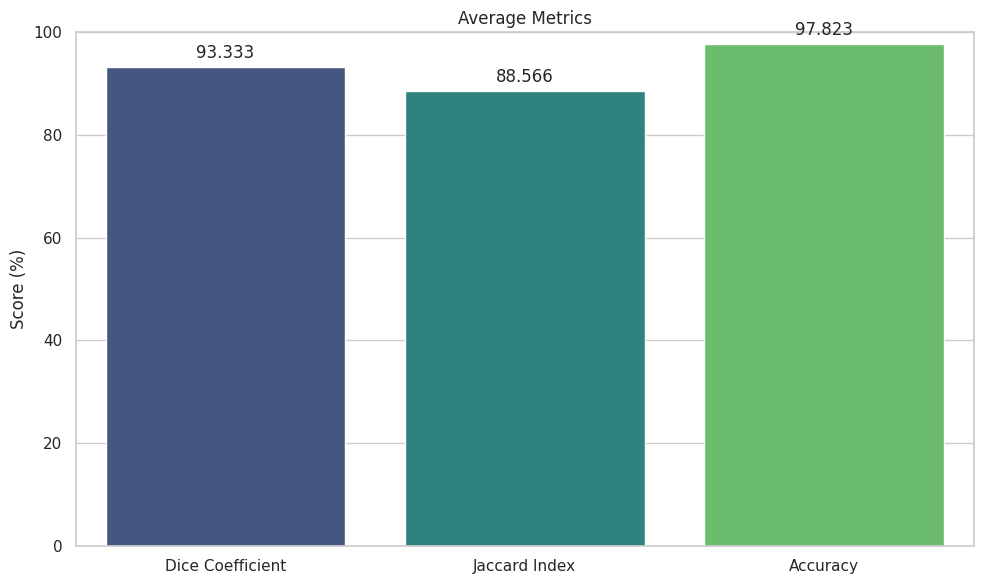

In [13]:
#Tính means :
mean_dice = np.mean(dice_scores) * 100
mean_jaccard = np.mean(jaccard_scores) * 100
mean_accuracy = np.mean(accuracy_scores) * 100

#Dữ liệu trực quan :
metrics = ['Dice Coefficient', 'Jaccard Index', 'Accuracy']
values = [mean_dice, mean_jaccard, mean_accuracy]

#Tạo biểu đồ cột :
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics, y=values, palette="viridis")

#Thêm giá trị của các metric lên cột :
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

#Thiết lập labels và title :
ax.set(ylim=(0, 100))
plt.ylabel('Score (%)')
plt.title('Average Metrics')

#Hiển thị biểu đồ :
plt.tight_layout()
plt.show()

# **Hiển thị ảnh đã phân đoạn :**

In [14]:
def Show_Images_Mask_Pred(x_test, y_true, binary_predictions, qual=10):
    top_qual = np.argsort(dice_scores)[-qual:]
    
    for i in top_qual :
        plt.figure(figsize=(15, 5))

        #Hệ số Dice Coef, Jaccard, Accuracy :
        print(f'Accuracy For Image {i}: {accuracy_scores[i]}')
        print(f'Dice Coefficent For Image {i}: {dice_scores[i]}')
        print(f'Jaccard For Image {i}: {jaccard_scores[i]}')

        plt.subplot(1, 4, 1)
        plt.imshow(x_test[i][...,::-1])
        plt.title('Ảnh Thật')
        plt.axis('off')  # Bỏ grid

        plt.subplot(1, 4, 2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title('Mặt Nạ Thật')
        plt.axis('off')  # Bỏ grid

            
        plt.subplot(1, 4, 3)
        plt.imshow(y_pred[i], cmap='gray')
        plt.title('Dự Đoán Chưa Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

    
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred_b[i], cmap='gray')
        plt.title('Dự Đoán Đã Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

        plt.show()
        print('='*80)

Accuracy For Image 17: 0.992156982421875
Dice Coefficent For Image 17: 0.9822040796279907
Jaccard For Image 17: 0.9650030639340914


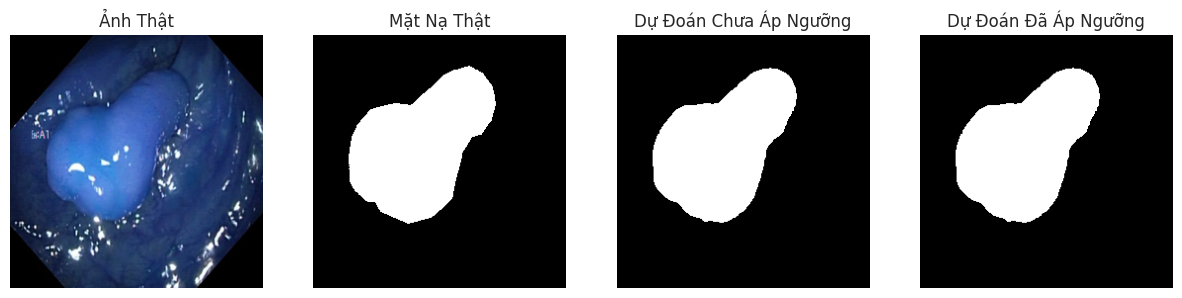

Accuracy For Image 61: 0.9920196533203125
Dice Coefficent For Image 61: 0.9829147458076477
Jaccard For Image 61: 0.9664334766703035


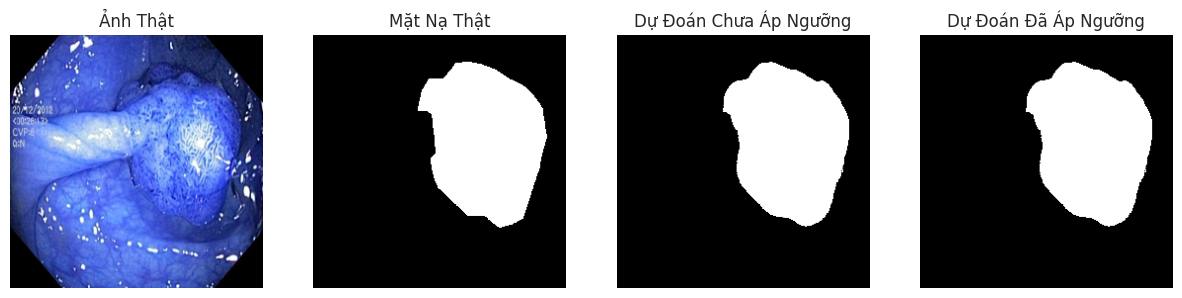

Accuracy For Image 69: 0.996337890625
Dice Coefficent For Image 69: 0.9831786155700684
Jaccard For Image 69: 0.9670555936856554


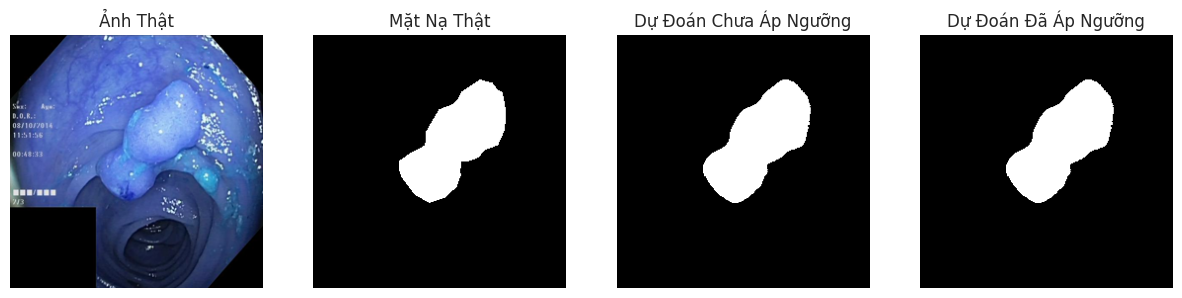

Accuracy For Image 75: 0.9932861328125
Dice Coefficent For Image 75: 0.9840956330299377
Jaccard For Image 75: 0.96875


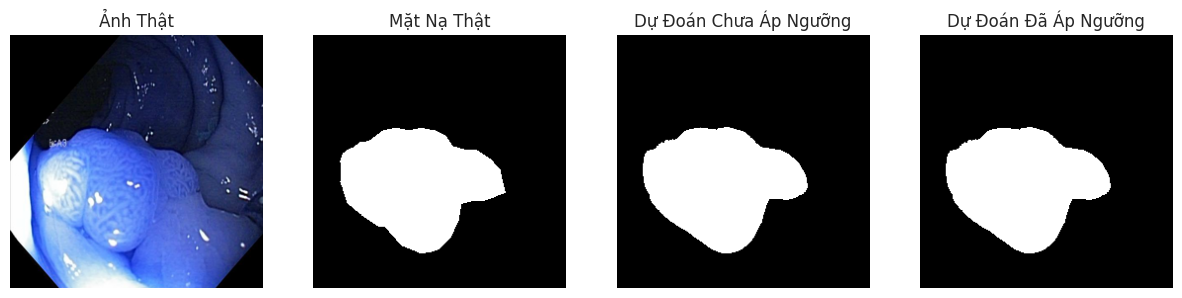

Accuracy For Image 22: 0.9914093017578125
Dice Coefficent For Image 22: 0.9849641919136047
Jaccard For Image 22: 0.9703371970495258


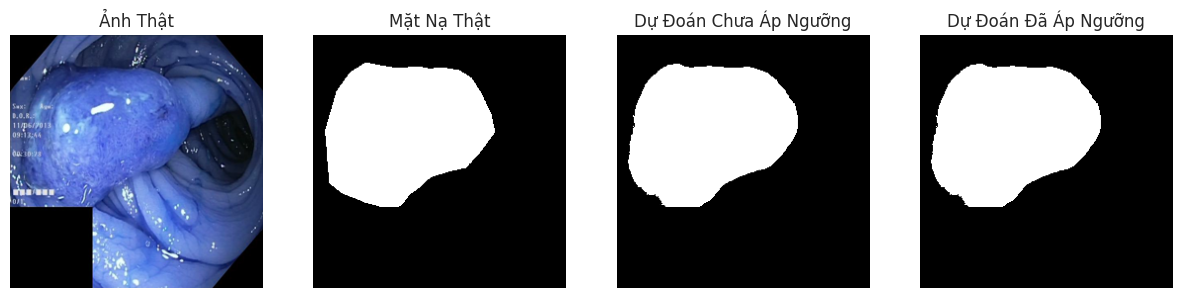

Accuracy For Image 26: 0.9969482421875
Dice Coefficent For Image 26: 0.9860901832580566
Jaccard For Image 26: 0.972822394347058


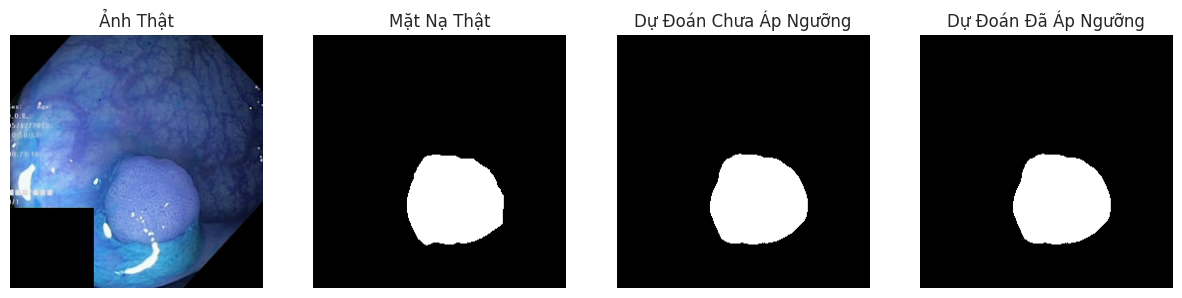

Accuracy For Image 37: 0.992279052734375
Dice Coefficent For Image 37: 0.9869396090507507
Jaccard For Image 37: 0.9741625816993464


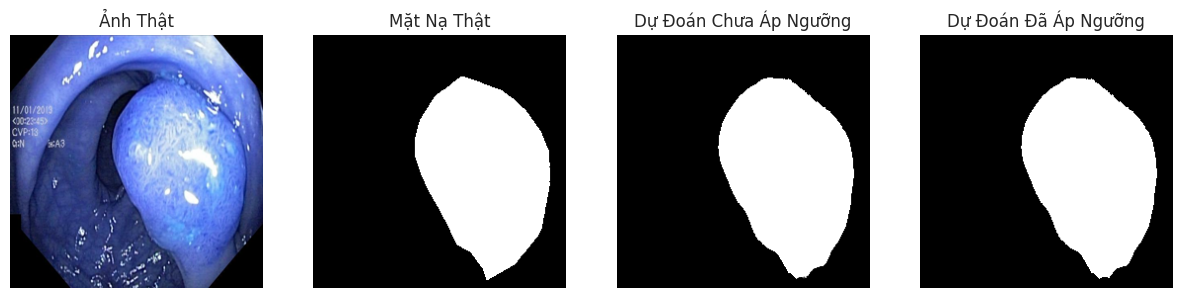

Accuracy For Image 48: 0.9962158203125
Dice Coefficent For Image 48: 0.987667977809906
Jaccard For Image 48: 0.975588148439807


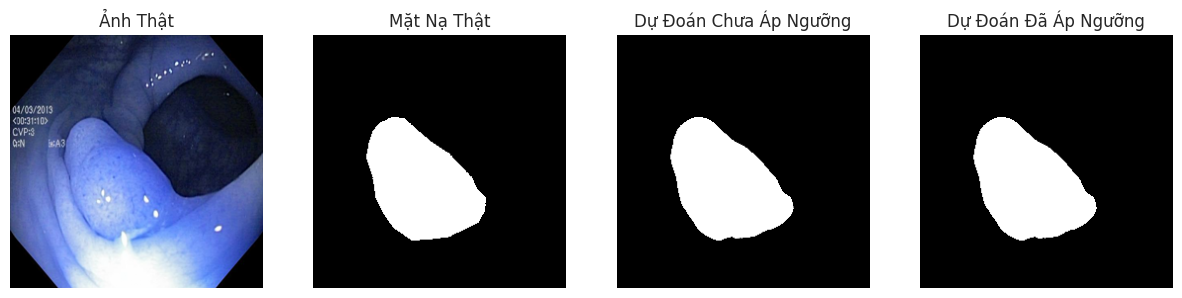

Accuracy For Image 85: 0.9925079345703125
Dice Coefficent For Image 85: 0.9878742098808289
Jaccard For Image 85: 0.9759266522847617


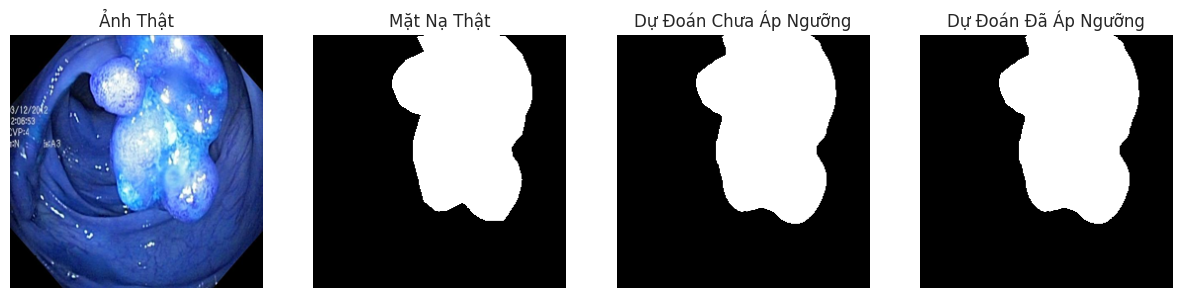

Accuracy For Image 19: 0.9939117431640625
Dice Coefficent For Image 19: 0.9885494709014893
Jaccard For Image 19: 0.9775008458328635


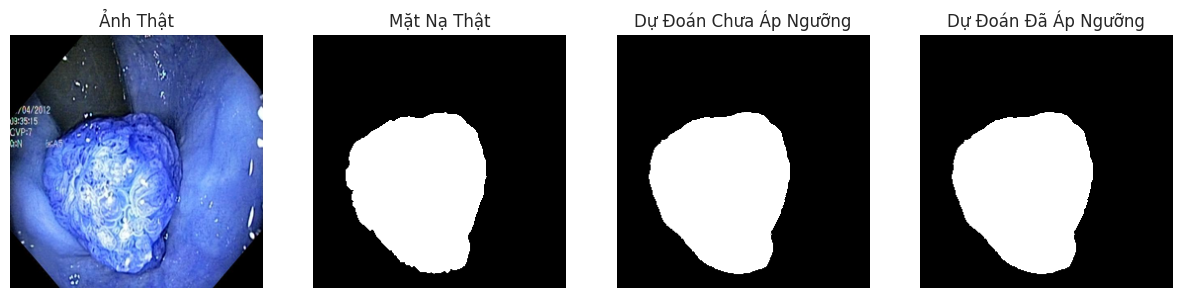

In [15]:
Show_Images_Mask_Pred(x_test , y_test, 
                      y_pred_b, 
                      qual = 10)